In [7]:
import os, pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


class EmpiricalDistribution(object):
    """base class for empirical distribtuions"""
    self.ndim = None
    self.param = None
    
    def draw(self):
        """draw a sample from the distribution"""
        raise NotImplementedError

    def prob(self, X):
        """pdf of distribution"""
        raise NotImplementedError

    def logprob(self, X):
        """logpdf of distribution"""
        raise NotImplementedError

class EmpiricalDistribution2D(object):
    def __init__(self, param_names, samples, bins):
        """
        :param samples: samples for hist
        :param bins: edges to use for hist (left and right)
            make sure bins cover whole prior!
        """
        self.ndim = 2
        self.param_names = param_names
        self._Nbins = [len(b)-1 for b in bins]
        hist, x_bins, y_bins = np.histogram2d(*samples, bins=bins)

        self._edges = np.array([x_bins[:-1], y_bins[:-1]])
        self._wids = np.diff([x_bins, y_bins])

        area = np.outer(*self._wids)
        hist += 1  # add a sample to every bin
        counts = np.sum(hist)
        self._pdf = hist / counts / area
        self._cdf = np.cumsum((self._pdf*area).ravel())

        self._logpdf = np.log(self._pdf)

    def draw(self):
        """draw a sample from the distribution"""
        draw = np.random.rand()
        draw_bin = np.searchsorted(self._cdf, draw)

        idx = np.unravel_index(draw_bin, self._Nbins)
        samp = [self._edges[ii, idx[ii]] + self._wids[ii, idx[ii]]*np.random.rand()
                for ii in range(2)]
        return np.array(samp)

    def prob(self, X):
        """pdf of distribution
        :param X: vector point in parameter space
        """
        ix, iy = (min(np.searchsorted(self._edges[ii], X[ii]),
                      self._Nbins[ii]-1) for ii in range(2))

        return self._pdf[ix, iy]

    def logprob(self, X):
        """log(pdf) of distribution at
        :param X: vector point in parameter space
        """
        ix, iy = (min(np.searchsorted(self._edges[ii], X[ii]),
                      self._Nbins[ii]-1) for ii in range(2))

        return self._logpdf[ix, iy]


class EmpiricalDistribution1D(object):

    def __init__(self, param_name, samples, bins):
        """
        :param samples: samples for hist
        :param bins: edges to use for hist (left and right)
        make sure bins cover whole prior!
        """
        self.ndim = 1
        self.param_name = param_name
        self._Nbins = len(bins)-1
        hist, x_bins = np.histogram(samples, bins=bins)

        self._edges = x_bins[:-1]
        self._wids = np.diff(x_bins)

        hist += 1  # add a sample to every bin
        counts = np.sum(hist)
        self._pdf = hist / float(counts) / self._wids
        self._cdf = np.cumsum((self._pdf*self._wids).ravel())

        self._logpdf = np.log(self._pdf)

    def draw(self):
        draw = np.random.rand()
        draw_bin = np.searchsorted(self._cdf, draw)

        idx = np.unravel_index(draw_bin, self._Nbins)
        samp = self._edges[idx] + self._wids[idx]*np.random.rand()
        return np.array(samp)

    def prob(self, params):
        ix = min(np.searchsorted(self._edges, params),
                 self._Nbins-1)

        return self._pdf[ix]

    def logprob(self, params):
        ix = min(np.searchsorted(self._edges, params),
                 self._Nbins-1)

        return self._logpdf[ix]

# generate Empirical Distribution objects

## load all-sky chain

In [2]:
ephem = 'DE436'
bayesephem = True
BE = '_BE' if bayesephem else ''
chunk = 'all'

rundir = '/home/pbaker/nanograv/bwm/allsky_rerun/{0:s}{1:s}/{2:s}/'.format(ephem, BE, chunk)

In [3]:
burnfrac = 0.55
thin = 100

chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                        sep='\t', dtype=float, header=None).values
burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

## generate param lists

In [4]:
with open(rundir + 'params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# make PSR list
psrlist = np.unique([par.split('_')[0] for par in params if par.startswith('J') or par.startswith('B')])

# make RN groups
RN_groups = []
for psr in psrlist:
    logA = psr + '_red_noise_log10_A'
    gam = psr + '_red_noise_gamma'
    RN_groups.append([gam, logA])

### make RN distr

In [132]:
distr = []

nbins = 41
Amin, Amax = -20, -11
gmin, gmax = 0, 7

for pars in RN_groups:
    # get the parameter indices
    idx = [params.index(pp) for pp in pars]

    # get the bins for the histogram
    bins = [np.linspace(gmin, gmax, nbins),
            np.linspace(Amin, Amax, nbins)]

    new_distr = EmpiricalDistribution2D(pars, chain[:, idx].T, bins)

    distr.append(new_distr)

In [135]:
datadir = '/home/pbaker/nanograv/data/'
distrfile = os.path.join(datadir, "nano11_RNdistr.pkl")
with open(distrfile, 'wb') as f:
        pickle.dump(distr, f)

In [22]:
class EmpDistrDraw(object):
    """object for empirical proposal distributions
    """
    def __init__(self, distr, parlist, Nmax=None, name=None):
        """
        :param distr: list of EmpiricalDistribution objects
        :param parlist: list of all model params (pta.param_names)
            to figure out which indices to use
        :param Nmax: maximum number of distributions to propose
            simultaneously
        :param name: name for PTMCMC bookkeeping
        """
        self._distr = distr
        self.Nmax = Nmax if Nmax else len(distr)        
        self.__name__ = name if name else 'draw_empirical'

        # which model indices go with which distr?
        for dd in self._distr:
            dd._idx = []
            if hasattr(dd, 'param_names')
            
            for pp in parlist:    
                if pp in dd.param_names:
                    dd._idx.append(parlist.index(pp))

    def __call__(self, x, iter, beta):
        """propose a move from empirical distribution
        """
        y = x.copy()
        lqxy = 0
        
        # which distrs to propose moves
        N = np.random.randint(1, self.Nmax)
        which = np.random.choice(self._distr, size=N, replace=False)
        
        for distr in which:
            old = x[distr._idx]
            new = distr.draw()
            y[distr._idx] = new

            lqxy += (distr.logprob(old) -
                     distr.logprob(new))

        return y, lqxy

In [119]:
Non4 = len(distr) // 4
myEmpDraw = EmpDistrDraw(distr, params, Nmax=Non4, name='draw_RNempirical')

In [256]:
x = chain[-5, :-5]
y, lqxy = myEmpDraw(x, 1, 1)

x-y, lqxy

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.67673034, 0.2210382 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.81141026, 0.44605377, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.68987024, 0.29618068, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

# make BE distr

In [9]:
# make BE group
jup_pars = [pp for pp in params if 'jup' in pp]

In [11]:
distrJup = []

nbins = 41
bins = np.linspace(-0.05, 0.05, nbins)

for par in jup_pars:
    # get the parameter indices
    idx = params.index(par)

    new_distr = EmpiricalDistribution1D(par, chain[:, idx], bins)

    distrJup.append(new_distr)

In [24]:
distrJup[0].param_name

'd_jupiter_mass'

In [23]:
myJupDraw = EmpDistrDraw(distrJup, params, Nmax=2, name='draw_JupEmpirical')

AttributeError: 'EmpiricalDistribution1D' object has no attribute 'param_names'

# use `kde` for `jup_orb_elements`

In [138]:
from scipy.stats import gaussian_kde

from corner import corner

### get `d_mass` and `jup_orb` chains

In [186]:
# jup orb elements
par_jup = []
for par in params:
    if par.startswith('jup_orb'):
        par_jup.append(par)
idx_jup = [params.index(p) for p in par_jup]
ch_jup = chain[:, idx_jup]

# d planet mass
par_mass = []
for par in params:
    if par.startswith('d_'):
        par_mass.append(par)
idx_mass = [params.index(p) for p in par_mass]
ch_mass = chain[:, idx_mass]

# frame drift rate
idx_fdr = params.index('frame_drift_rate')
ch_fdr = chain[:, idx_fdr]

In [295]:
class UniformKDE(object):
    """dummy KDE-like object for 1D uniform parameter
    """
    def __init__(self, low, high):
        self._low = low
        self._high = high
        self._A = 1/(high-low)
        self._logA = np.log(self._A)
        
        self.evaluate = self.pdf

    def __call__(self, x):
        return self.pdf(x)

    def pdf(self, x):
        if x > self._low and x < self._high:
            return self._A
        else:
            return 0

    def logpdf(self, x):
        if x > self._low and x < self._high:
            return self._logA
        else:
            return -np.inf
    
    def resample(self, size=None):
        return np.random.uniform(self._low, self._high, size=size)


class BayesEphemKDEDraw(object):
    """object for bayesephem proposal distribution
    """
    def __init__(self, mass, fdr, jup, parlist, name='draw_BE'):
        """
        :param mass: d_planet_mass gaussian_KDE object
        :param fdr: frame_drift_rate UniformKDE object
        :param fdr: jup_orb_elements gaussian_KDE object
        :param parlist: list of all model params (pta.param_names)
            to figure out which indices to use
        :param name: name for PTMCMC bookkeeping
        """
        self.__name__ = name

        # which model indices go with which distr?
        mass._idx = []
        fdr._idx = []
        jup._idx = []
        for pp in parlist:
            if pp.startswith('d_'):
                mass._idx.append(parlist.index(pp))
            if pp.startswith('frame_'):
                fdr._idx.append(parlist.index(pp))
            if pp.startswith('jup_orb_'):
                jup._idx.append(parlist.index(pp))
        
        self._distr = {'mass':mass,
                       'fdr':fdr,
                       'jup':jup}        

    def __call__(self, x, iter, beta):
        """propose a move from KDE distribution
        """
        y = x.copy()
        lqxy = 0
        
        # move all of 'em every time!
        for dd in self._distr.values():
            old = x[dd._idx]
            new = dd.resample(size=1).T
            y[dd._idx] = new

            lqxy += (dd.logpdf(old) -
                     dd.logpdf(new))

        return y, lqxy
    
class JupOrb_KDE_Draw(object):
    """object for bayesephem proposal distribution
    """
    def __init__(self, jup_kde, parlist, name='jup_kde'):
        """
        :param mass: d_planet_mass gaussian_KDE object
        :param fdr: frame_drift_rate UniformKDE object
        :param fdr: jup_orb_elements gaussian_KDE object
        :param parlist: list of all model params (pta.param_names)
            to figure out which indices to use
        :param name: name for PTMCMC bookkeeping
        """
        self.__name__ = name

        # which model indices?
        jup_kde._idx = [parlist.index(pp)
                        for pp in parlist if pp.startswith('jup_orb')]
        
        self._distr = jup_kde

    def __call__(self, x, iter, beta):
        """propose a move from KDE distribution
        """
        y = x.copy()

        # move all of 'em simultaneously
        dd = self._distr
        old = x[dd._idx]
        new = dd.resample(size=1).T
        y[dd._idx] = new

        lqxy = (dd.logpdf(old) - dd.logpdf(new))[0]

        return y, lqxy

In [296]:
mass_kde = gaussian_kde(ch_mass.T)
fdr_kde = UniformKDE(low=-1e-9, high=1e-9)
jup_kde = gaussian_kde(ch_jup.T)

In [297]:
myBEdraw = BayesEphemKDEDraw(mass_kde, fdr_kde, jup_kde, params)

In [298]:
x = chain[-5, :-5]
y, lqxy = myBEdraw(x, 1, 1)

x-y, lqxy

(array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.0

In [299]:
myJupDraw = JupOrb_KDE_Draw(jup_kde, params)

In [310]:
x = chain[-5, :-5]
y, lqxy = myJupDraw(x, 1, 1)

x-y, lqxy

(array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.0

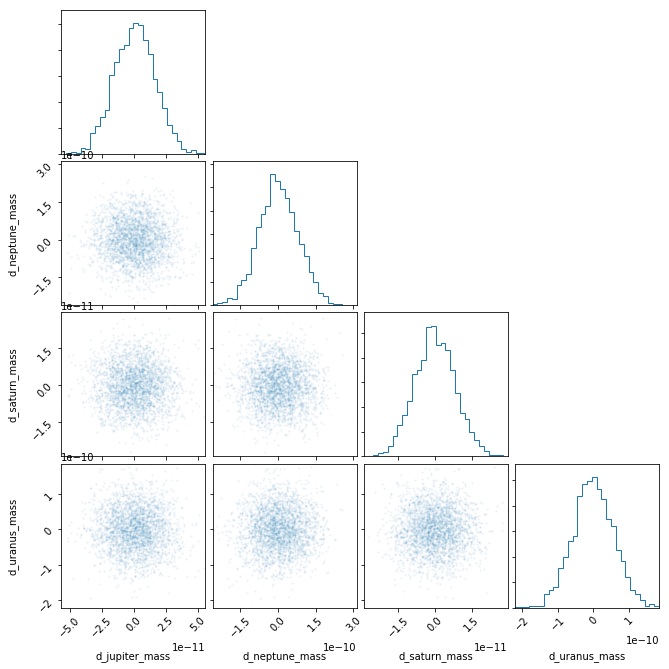

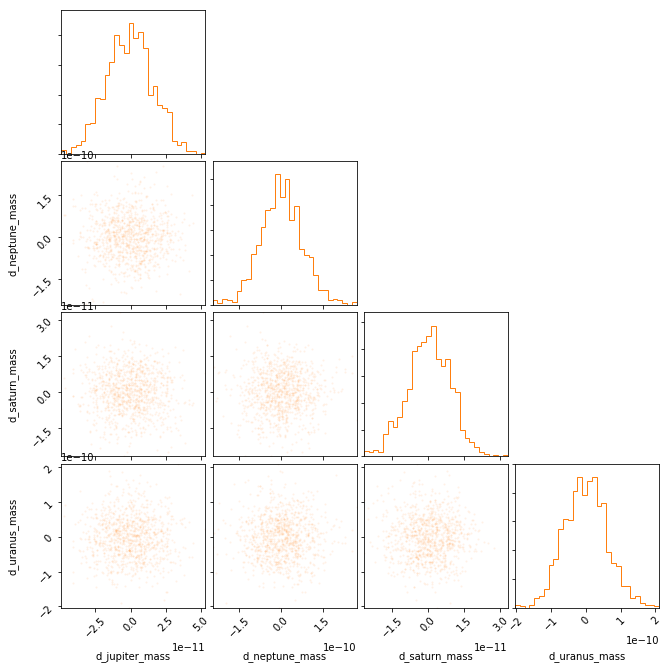

In [183]:
corner_kwargs = {'bins':30,
                 #'show_titles':True,
                 'labels':par_mass,
                 'smooth':0.25,
                 'plot_datapoints':True,
                 'plot_density':False,
                 'plot_contours':False,
                 'fill_contours':False,}

corner(ch_mass[::5], color='C0', **corner_kwargs);

corner(mass_kde.resample(size=1000).T, color='C1', **corner_kwargs);

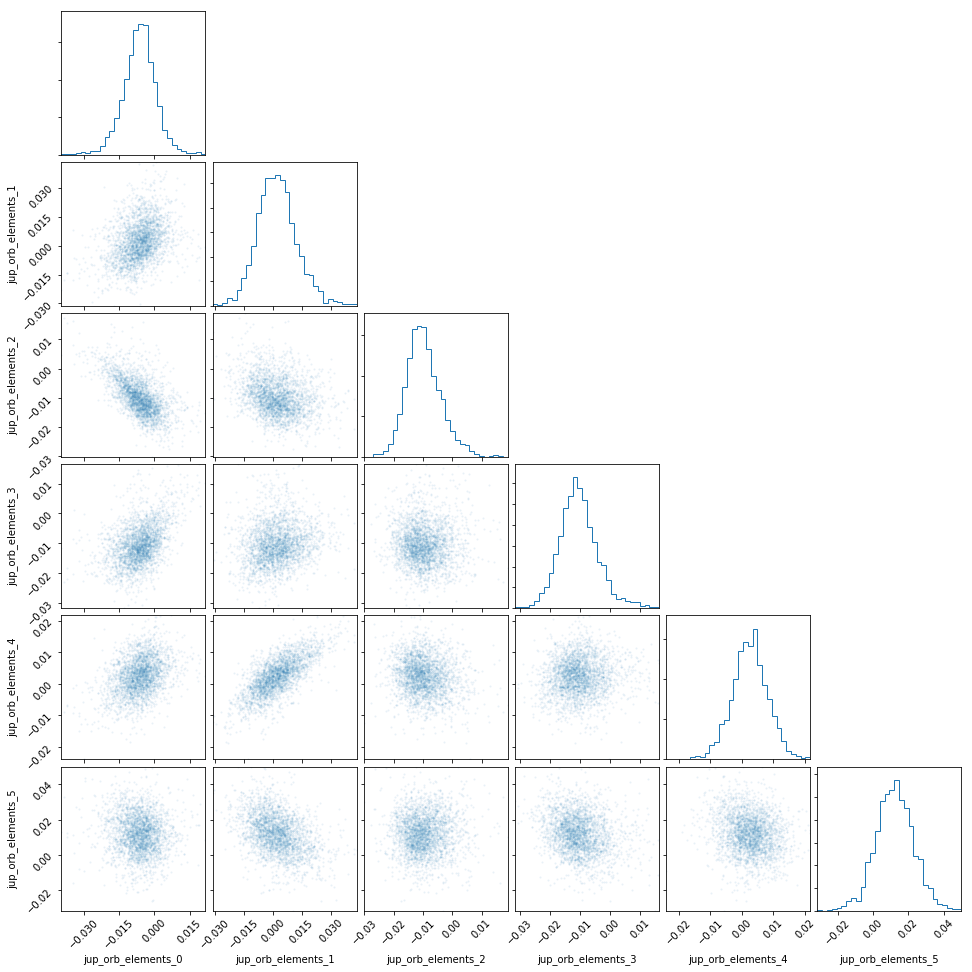

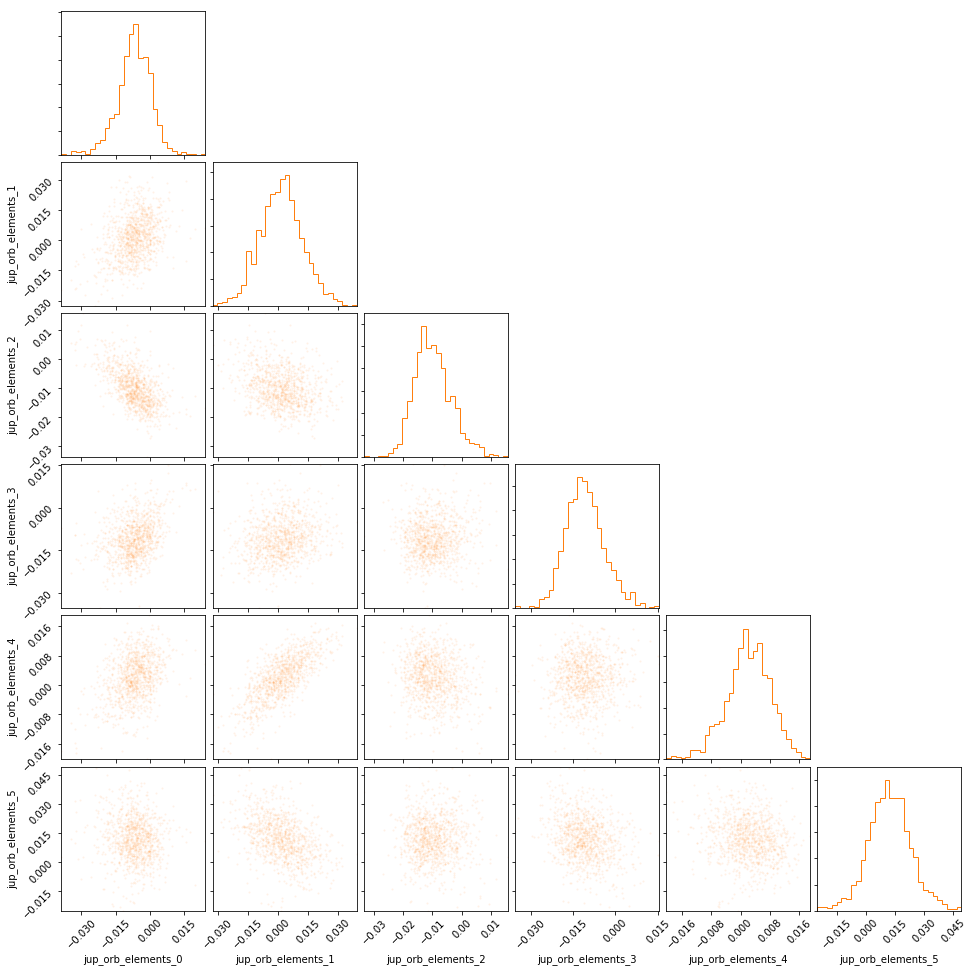

In [173]:
corner_kwargs = {'bins':30,
                 #'show_titles':True,
                 'labels':par_jup,
                 'smooth':0.25,
                 'plot_datapoints':True,
                 'plot_density':False,
                 'plot_contours':False,
                 'fill_contours':False,}

corner(ch_jup[::5], color='C0', **corner_kwargs);

corner(jup_kde.resample(size=1000).T, color='C1', **corner_kwargs);

In [219]:
jup_kde.resample(size=1).T[0]

array([-0.00999899, -0.00820437, -0.00939612, -0.01857133, -0.00251006,
        0.0269083 ])

In [ ]:
def draw_BE_KDE(x, iter, beta):
    y = x.copy
    

In [272]:
datadir = '/home/pbaker/nanograv/data/'
kdefile = os.path.join(datadir, "nano11_jup_kde.pkl")
with open(kdefile, 'wb') as f:
        pickle.dump(jup_kde, f)